## Text classification on LeMonde2003 Dataset

In this notebook, we 
apply classification algorithms to newspaper articles published in 2003 in *Le Monde*. 

The data are in data/LeMonde2003_9classes.csv.gz

These articles concern different subjects but we will consider only articles related to the following subjects : entreprises (ENT), international (INT), arts (ART), société (SOC), France (FRA), sports (SPO), livres (LIV), télévision (TEL) and the font page articles (UNE).


> * Load the CSV file `data/LeMonde2003_9classes.csv` containing the articles using pandas [pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). How many articles do you have ? 
> * Plot the frequency histogram of the categories using seaborn [countplot](https://seaborn.pydata.org/tutorial/categorical.html) : `sns.countplot(data=df,y='category')`
> * Display the text of some of the article with the corresponding class using pandas [indexing](https://pandas.pydata.org/pandas-docs/version/0.17.0/indexing.html#indexing-integer)
> * Using the [WordCloud library](https://amueller.github.io/word_cloud/index.html), display a word cloud for the most frequent classes. You can remove the stop words using the `stopwords` option, using the list of stop words in French in `data/stop_word_fr.txt`.



In [1]:
import pandas as pd

# load dataframe from CSV file
data=pd.read_csv("data/LeMonde2003_raw.csv")
data.head(5)

,text,category
0,"A la boutique du Fulham FC, nichée au dernier ...",SPO
1,"IL Y A près d'un an, en pleine campagne présid...",TER
2,"Pour la plupart de ceux qui n'y vivent pas, la...",ART
3,L'explosion s'est produite à 6 h 26. Maryan pr...,TER
4,LA PERSPECTIVE d'une enquête judiciaire sur la...,FRA


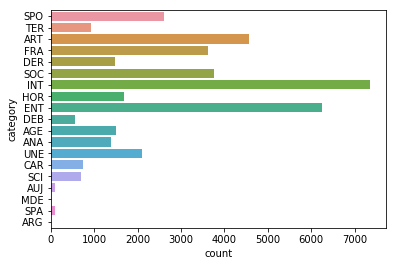

In [2]:
import seaborn as sns
%matplotlib inline

# Plot the statistics of category
sns.countplot(data=data,y='category')

In [16]:
# Drop nan values for text 
data.dropna(inplace=True)

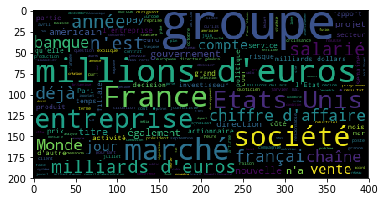

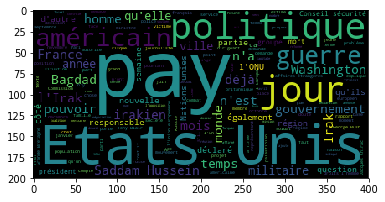

In [17]:
# WordCloud for two most frequent class
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
stop_words = np.loadtxt("data/stop_word_fr.txt",dtype=str)
SPA=" ".join(data[data["category"]=="ENT"]["text"])
INT=" ".join(data[data["category"]=="INT"]["text"])
# Display one wordcloud for each of the most frequent classes
w_spa=WordCloud(stopwords=stop_words).generate(SPA)
w_int=WordCloud(stopwords=stop_words).generate(INT)
plt.imshow(w_spa)
plt.figure()
plt.imshow(w_int)

## Bag-of-word representation

In order to apply machine learning algorithms to text, documents must be transformed into vectors. The most simple and standard way to transform a document into a vector is the *bag-of-word* encoding.

The idea is very simple : 

1. define the set of all the possible words that can appear in a document; denote its size by `max_features`.
2. for each document,  encode it with a vector of size `max_features`, with the value of the ith component of the vector equal to the number of time the ith word appears in the document.

See [the wikipedia article on Bag-of-word](https://en.wikipedia.org/wiki/Bag-of-words_model) for an example.

Scikit-learn proposes different methods to encode text into vectors : [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

The encoder must first be trained on the train set and applied to the different sets, for example with the 1000  words : 

	from sklearn.feature_extraction.text import CountVectorizer
	vectorizer = CountVectorizer(max_features=1000)
    vectorizer.fit(X_train)
    X_train_counts = vectorizer.transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
        
**Question**:

> * Split the dataset LeMonde2003 into train set (60%), dev set (20%)  and test set (20%) using scikit-learn [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
> * For each set, transform the text of the articles into vectors using the `CountVectorizer`, considering the 2000 most frequent words. 
> * train a naive bayes classifier on the data. Evaluate the classification accuracy on the train, dev and test sets.

> ***Important*** : the test set must not be used during the training phase, and learning the vector representation of the words is part of the training. The dev set should be an evaluation of the test set.



In [3]:
from sklearn.model_selection import train_test_split
# Split the dataset, create X (features) and y (target), print the size
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["category"], test_size=0.40)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5)
print("In Train : {} exemples".format(X_train.shape[0]))
print( "In Dev : {} exemples".format(X_dev.shape[0]))
print( "In Test : {} exemples".format(X_test.shape[0]))

In Train : 23670 exemples
In Dev : 7891 exemples
In Test : 7890 exemples


In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# Create document vectors
vectorizer = CountVectorizer(max_features=2000,stop_words=list(stop_words))
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [24]:
from sklearn.naive_bayes import GaussianNB
# Train a Naive Bayes classifier
clf_bag = GaussianNB()
clf_bag.fit(X_train_counts.toarray(), y_train)
print(clf_bag.score(X_train_counts.toarray(),y_train)," : Train_accuracy")
print(clf_bag.score(X_test_counts.toarray(),y_test)," : Test_accuracy")

0.44613159797541574  : Train_accuracy
0.4274193548387097  : Test_accuracy


## TF-IDF representation

The `CountVectorizer` encodes the text using the raw frequencies of the words. However, words that are very frequent and appear in all the documents will have a strong weight whereas they are not discriminative. The *Term-Frequency Inverse-Document-Frequency* weighting scheme take into accound the number of documents in which a given word occurs. A word that appear in many document will have less weight. See [the wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for more details.

With scikit-learn, the `TfidfTransformer` is applied after the `CountVectorizer` :

	from sklearn.feature_extraction.text import TfidfTransformer
	tf_transformer = TfidfTransformer().fit(X_train_counts)
 	X_train_tf = tf_transformer.transform(X_train_counts)
	X_test_tf = tf_transformer.transform(X_test_counts)
	
**Question**:

> * Use the TF-IDF representation to train a Multinomial Naive Bayes classifier. Report your best test error rate and the error rates for all the configurations tested.

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
clf_idf = MultinomialNB()
clf_idf.fit(X_train_tf, y_train)
print(clf_idf.score(X_train_tf,y_train)," : Train Accuracy score")
print(clf_idf.score(X_test_tf,y_test)," : Test Accuracy score")

0.6672195993364808  : Train Accuracy score
0.6641996733360556  : Test Accuracy score


## Error analysis

The classification error rate give an evaluation of the performance for all the classes. But since the classes are not equally distributed, they may not be equally well modelized. In order to get a better idea of the performance of the classifier, detailed metrics must be used : 

* [metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) provides a detailed analysis per class : the precision (amongst all the example classified as class X, how many are really from the classX) and the recall (amongst all the example that are from the class X, how many are classified as class X) and the F-Score which is as a weighted harmonic mean of the precision and recall.
* [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) which give the confusions between the classes. It can be displayed in color with [plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix).

**Question**:

> * Report the `classification_report` for your  classifier. Which classes have the best scores ? Why ?
> * Report the `confusion_matrix` for your  classifier. Which classes are the most confused ? Why ?


In [51]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# For bag of word 
y_pred_b=clf_bag.predict(X_test_counts.toarray())
pd.DataFrame(classification_report(y_test, y_pred_b,output_dict=True))

/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,AGE,ANA,ARG,ART,AUJ,CAR,DEB,DER,ENT,FRA,...,MDE,SCI,SOC,SPA,SPO,TER,UNE,micro avg,macro avg,weighted avg
f1-score,0.482117,0.147826,0.0,0.610538,0.190751,0.188811,0.436073,0.099718,0.509333,0.566970,...,0.0,0.298923,0.452216,0.041488,0.574778,0.292733,0.051522,0.427419,0.307029,0.469772
precision,0.383476,0.212500,0.0,0.849402,0.110000,0.106544,0.315702,0.154971,0.800405,0.708943,...,0.0,0.190939,0.640824,0.021434,0.602032,0.192204,0.127413,0.427419,0.341295,0.607804
recall,0.649077,0.113333,0.0,0.476531,0.717391,0.828645,0.704797,0.073509,0.373505,0.472373,...,0.0,0.688047,0.349385,0.644444,0.549884,0.613734,0.032290,0.427419,0.424458,0.427419
support,758.000000,600.000000,1.0,2237.000000,46.000000,391.000000,271.000000,721.000000,3178.000000,1846.000000,...,1.0,343.000000,1869.000000,45.000000,1293.000000,466.000000,1022.000000,19592.000000,19592.000000,19592.000000


The best score is the best f1-score because it's the trade-off between precision and recall.   
The best value is for the ART class.

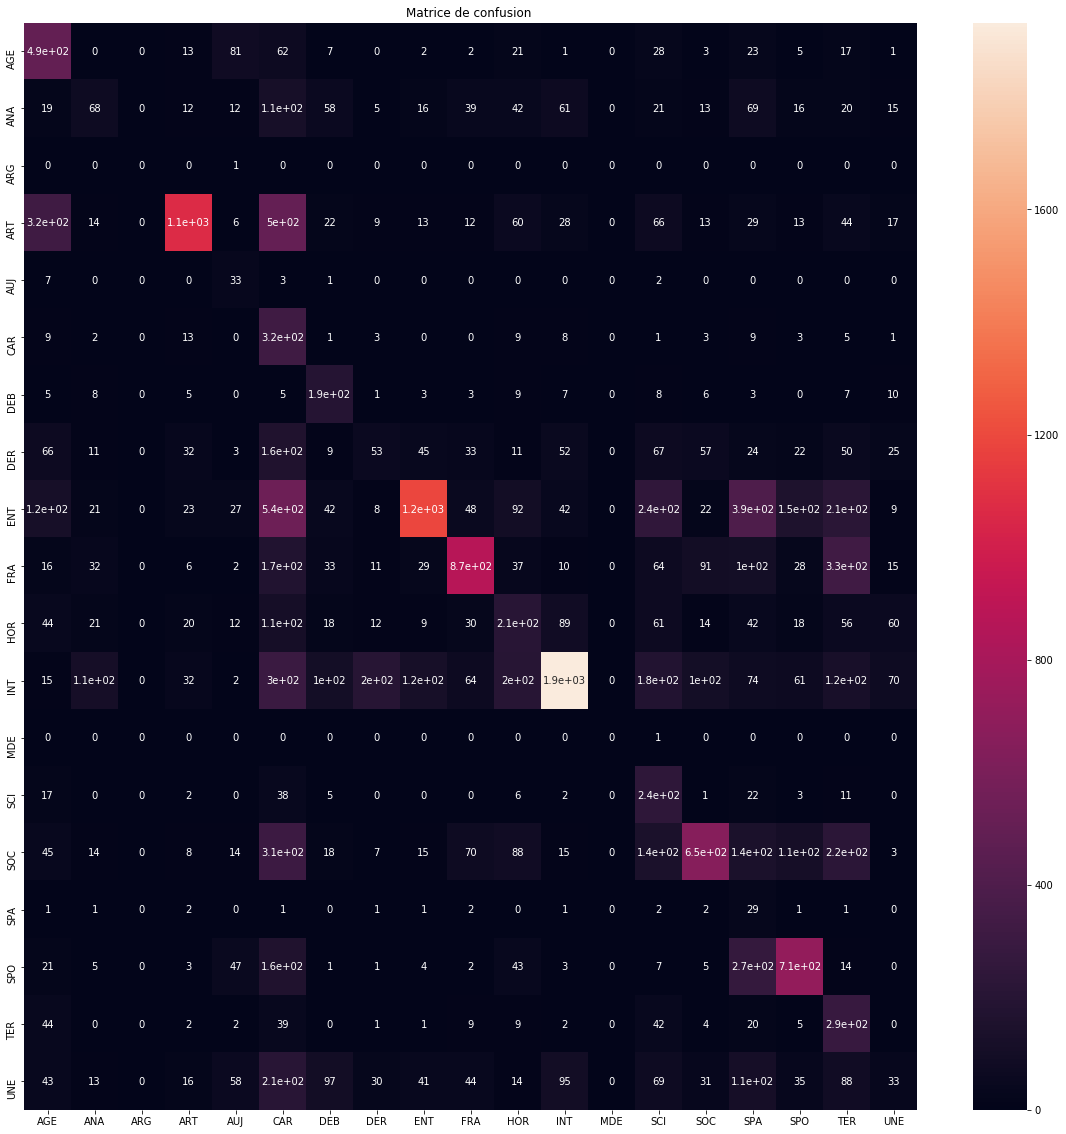

In [47]:
confusion = confusion_matrix(y_test,y_pred_b)
df_cm = pd.DataFrame(confusion, index = np.unique(data.category),
                  columns = np.unique(data.category))
plt.figure(figsize = (20,20))
plt.title("Matrice de confusion ")
sns.heatmap(df_cm, annot=True)

Several classes have no good classified exemples.

In [48]:
# For tf_idf
y_pred_t=clf_idf.predict(X_test_counts.toarray())
pd.DataFrame(classification_report(y_test, y_pred_t,output_dict=True))

/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,AGE,ANA,ARG,ART,AUJ,CAR,DEB,DER,ENT,FRA,...,MDE,SCI,SOC,SPA,SPO,TER,UNE,micro avg,macro avg,weighted avg
f1-score,0.682115,0.323232,0.0,0.777215,0.0,0.711462,0.371508,0.325486,0.811705,0.626272,...,0.0,0.627160,0.638079,0.0,0.876039,0.506455,0.074858,0.669712,0.442869,0.647641
precision,0.620541,0.494845,0.0,0.735917,0.0,0.733696,0.298876,0.621094,0.790982,0.556116,...,0.0,0.543897,0.588608,0.0,0.856615,0.471349,0.222222,0.669712,0.455595,0.647595
recall,0.757256,0.240000,0.0,0.823424,0.0,0.690537,0.490775,0.220527,0.833543,0.716685,...,0.0,0.740525,0.696629,0.0,0.896365,0.547210,0.045010,0.669712,0.458966,0.669712
support,758.000000,600.000000,1.0,2237.000000,46.0,391.000000,271.000000,721.000000,3178.000000,1846.000000,...,1.0,343.000000,1869.000000,45.0,1293.000000,466.000000,1022.000000,19592.000000,19592.000000,19592.000000


The best score is the best f1-score because it's the trade-off between precision and recall.   
The best value is for the ART class.

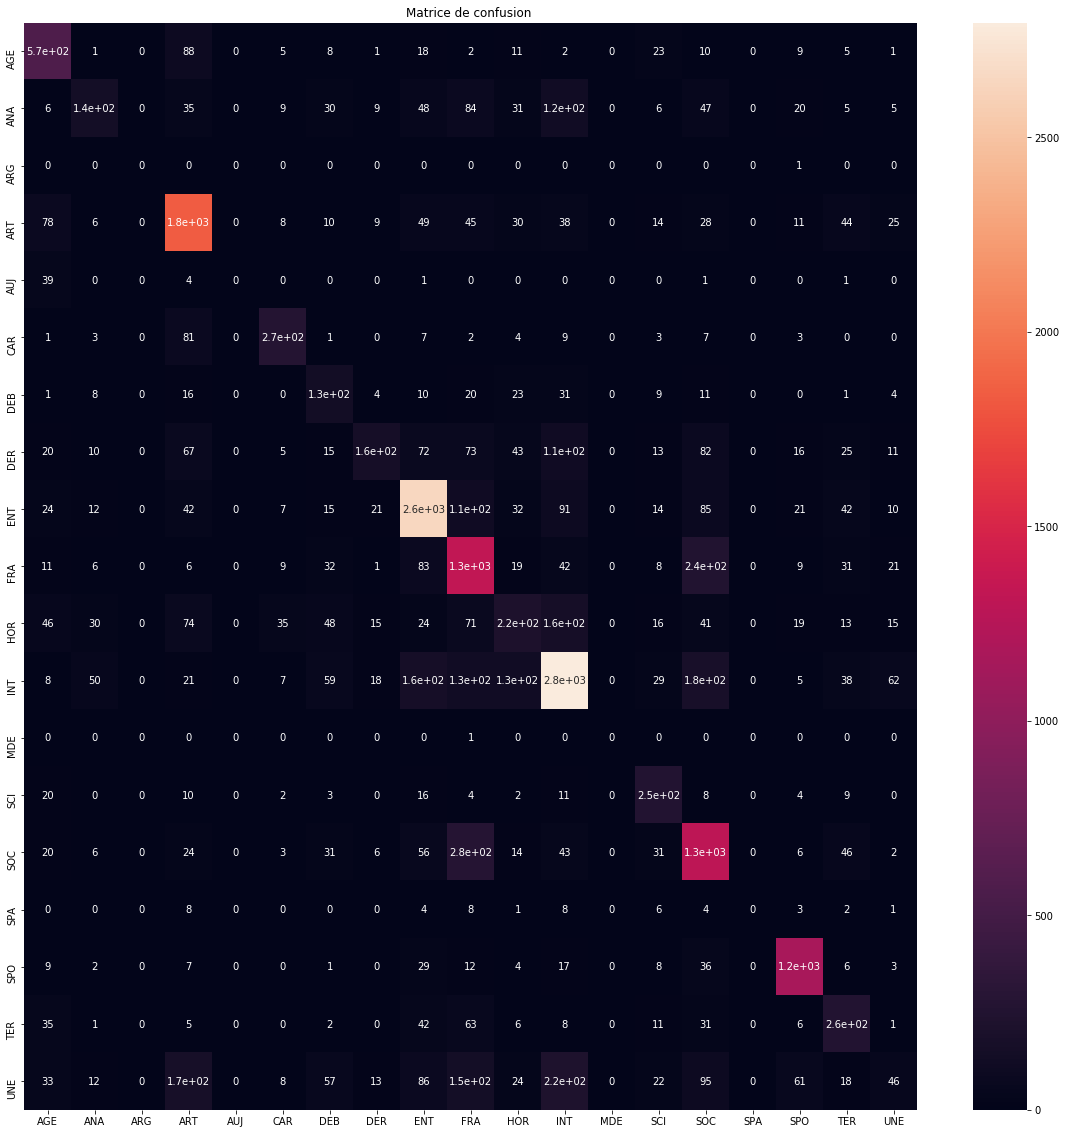

In [50]:
confusion = confusion_matrix(y_test,y_pred_t)
df_cm = pd.DataFrame(confusion, index = np.unique(data.category),
                  columns = np.unique(data.category))
plt.figure(figsize = (20,20))
plt.title("Matrice de confusion ")
sns.heatmap(df_cm, annot=True)

Several classes have no good classified exemples.

## Hyperparameter optimization

The classification process has many parameters : alpha for the classifier, max_features, max_df, min_df, using idf or not, ngram orders for the Count of TfIDF transformer. These parameters can be optimized by a grid search using GridSearchCV.

**Question**:

> * Using the template code below, find the best values for the parameter alpha,  max_features, max_df, min_df, use_idf, ngram_range


In [54]:
# Concatenate Train and valid to perform cross-validation
import random
random.seed(5)
X_train_dev=np.hstack((X_train,X_dev))
y_train_dev=np.hstack((y_train,y_dev))
np.random.shuffle(np.array(X_train_dev))
np.random.shuffle(np.array(y_train_dev))

In [119]:
# Hyperameters optimization with GridSearchCV = parallel processing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])


parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__min_df': (0.01,0.1),
    'clf__alpha' : (0,10,100),
    'vect__max_features' : (10,100,1000),
    "tfidf__use_idf" : (True,False),
    "vect__ngram_range" : ((1,1),(1,2),(2,2),(2,3))
}
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train_dev[:1000], y_train_dev[:1000])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0, 10, 100),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (10, 100, 1000),
 'vect__min_df': (0.01, 0.1),
 'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (2, 3))}
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.9min


KeyboardInterrupt: 

To long to end .

## Classification with Neural networks

Neural networks can be trained to learn both the vector representation of the words (instead of tf-idf) and how to classify the documents. The code below allows you to train a neural text classifier using word embeddings using Keras. Most of the code is written, you only have to define the architecture of the network with the correct parameters before training it : 

**Question**:

> * Define a neural network in the function `get_model()` with the following parameters : 
>  * use only the 10 000 most frequent words in the documents
>  * use 1024 as the maximal number of words in the articles
>  * use an embedding size of 300:  [embedding layer](https://keras.io/layers/embeddings/)
>  * use a dropout of 0.5:  [dropout layer](https://keras.io/layers/core/#dropout)
>  * use 32 convolutional filters of size 2 x EMBED_SIZE: [1D convolutional layer](https://keras.io/layers/convolutional/#conv1d)
>  * use a max pooling of size 2 : [1D Max Pooling](https://keras.io/layers/pooling/#maxpooling1d)
> * Train the model and compare its accuracy to the Naive Bayes models.



In [56]:
import ast
import os
from nn_utils import TrainingHistory
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from keras.preprocessing import text, sequence



Using TensorFlow backend.
/home/guyomard/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/guyomard/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/guyomard/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/guyomard/anaconda3/lib/python3.6/site-packag

In [57]:
# Model parameters
MAX_FEATURES = 10_000
MAX_TEXT_LENGTH = 1024
EMBED_SIZE  = 300
BATCH_SIZE = 16
EPOCHS = 10
VALIDATION_SPLIT = 0.1

In [13]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)



def get_model():

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_FEATURES, BATCH_SIZE)(inp)
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2*EMBED_SIZE, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(17, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y, history):
    
    model.fit(x_train, y,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


# Get the list of different classes
CLASSES_LIST = np.unique(y_train)
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert clas string to index
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(X_train, X_test)
print(len(x_vec_train), len(x_vec_test))

# define the NN topology
model = get_model()

# Define training procedure
history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)


print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
2062 1718
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1024, 16)          160000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024, 16)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1024, 32)          307232    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
______________________________________________________________

/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guyomard/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, wa